<h1 style="text-align:center">ANALYZING THE SIMILARITY OF U.S. CITIES</h1>


<h3 style="text-align:center">ADAMM HOCKMAN</h3>
<h6 style="text-align:center">IBM DATA SCIENCE CERTIFICATION - COURSERA.ORG</h6>

<h4 style="text-align:center">25 MAY 2020</h4>

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><b>Load and process the primary dataset.</b></li>
        <li>Load and process the secondary dataset.</li>
        <li>Acquire Foursquare data.</li>
        <li>Cluster the cities.</li>
        <li>Exploratory Data Analysis.</li>
        <li>Inferential Statistics.</li>
        </li>Machine Learning Algorithms.</li>
    </ol>
</div>
<br>
<hr>

<h3>Install and import any packages we will need.</h3>

In [2]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from pandas.io.json import json_normalize
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from geopy.geocoders import Nominatim
import us
import time
import folium
import requests # library to handle requests
from sklearn.cluster import KMeans 
from sklearn.datasets import make_blobs
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

<h2>Load and process the primary dataset.</h2>

<ul>
    <li>The dataset comes directly from the US Census Bureau, <a href='https://www.census.gov/data/tables/time-series/demo/popest/2010s-total-cities-and-towns.html'>More Info</a>.</li>
    <li>The data contains all (~19k) cities in the US recognized by the census.</li>
    <li>The columns include estimated population totals from 2010-2019.</li>
</ul>

<h4>Cleaning the main dataset</h4>
<ul>
    <li>Remove the last 5 rows of data; they are meaningless.</li>
    <li>Remove the unnecessary columns (census and estimates base).</li>
    <li>Remove population totals from 2010-2018 and replace with growth rate.</li>
    <li>Split the column containing the area name into three separate columns: City Name, City Type, and State</li>
</ul>

In [15]:


all_cities_df.head()

(19507, 13)


,Unnamed: 0,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"Abbeville city, Alabama",2688,2705.0,2699.0,2694.0,2643.0,2628.0,2608.0,2600.0,2584.0,2575.0,2571.0,2560.0
1,"Adamsville city, Alabama",4522,4506.0,4500.0,4493.0,4471.0,4449.0,4420.0,4390.0,4356.0,4327.0,4308.0,4281.0
2,"Addison town, Alabama",758,754.0,751.0,750.0,743.0,742.0,739.0,734.0,731.0,726.0,723.0,718.0
3,"Akron town, Alabama",356,356.0,355.0,347.0,347.0,343.0,338.0,339.0,333.0,332.0,331.0,328.0
4,"Alabaster city, Alabama",30352,31112.0,31209.0,31375.0,31684.0,31980.0,32182.0,32772.0,33017.0,33275.0,33413.0,33487.0


In [28]:
# read the file directly from census
load_df = pd.read_excel('https://www2.census.gov/programs-surveys/popest/tables/2010-2019/cities/totals/SUB-IP-EST2019-ANNRES.xlsx', skiprows=3, index_col=None)
load_df.head()

,Unnamed: 0,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"Abbeville city, Alabama",2688,2705.0,2699.0,2694.0,2643.0,2628.0,2608.0,2600.0,2584.0,2575.0,2571.0,2560.0
1,"Adamsville city, Alabama",4522,4506.0,4500.0,4493.0,4471.0,4449.0,4420.0,4390.0,4356.0,4327.0,4308.0,4281.0
2,"Addison town, Alabama",758,754.0,751.0,750.0,743.0,742.0,739.0,734.0,731.0,726.0,723.0,718.0
3,"Akron town, Alabama",356,356.0,355.0,347.0,347.0,343.0,338.0,339.0,333.0,332.0,331.0,328.0
4,"Alabaster city, Alabama",30352,31112.0,31209.0,31375.0,31684.0,31980.0,32182.0,32772.0,33017.0,33275.0,33413.0,33487.0


In [30]:
all_cities_df = load_df.copy()
# rename and drop columns; drop last 5 rows of df
all_cities_df.rename(columns={'Unnamed: 0':'Geographic Area', 2019:'Population 2019'}, inplace=True)
all_cities_df['Growth (% since 2010)'] = all_cities_df['Population 2019'] / all_cities_df[2010]
all_cities_df.drop(columns=['Census', 'Estimates Base', 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], inplace=True)
all_cities_df.drop(all_cities_df.tail().index, inplace=True)
all_cities_df['Population 2019'] = all_cities_df['Population 2019'].astype('int32')

# define functions to extract the 'city type' (i.e. town or city), the 'city name', and the 'state'.
def extract_state(area):
    st = re.findall(r"^.+,\s(.+)$", area)
    if len(st) == 0:
        return "NONE"
    return st[0]

def extract_designation(area):
    de = re.findall(r"^.+\s(.+),\s.+$", area)
    if len(de) == 0:
        return "NONE"
    return de[0]

def extract_area(area):
    ar = re.findall(r"^(.+)\s.+,\s.+$", area)
    if len(ar) == 0:
        return "NONE"
    return ar[0]

# add the three separate corresponding columns and save
state_list = all_cities_df['Geographic Area']
all_cities_df['City Name'] = state_list.apply(extract_area)
all_cities_df['State'] = state_list.apply(extract_state)
all_cities_df['City Type'] = state_list.apply(extract_designation)

# remove original column
all_cities_df.drop(columns=['Geographic Area'], inplace=True)

# rearrange the columns
cols = all_cities_df.columns.tolist()
cols = cols[-3:] + cols[0:-3]
all_cities_df = all_cities_df[cols]

# save and view
all_cities_df.to_csv('./data/all_cities_data.csv')
print(all_cities_df.shape)
all_cities_df.head()
#all_cities_df.tail()

(19502, 5)


,City Name,State,City Type,Population 2019,Growth (% since 2010)
0,Abbeville,Alabama,city,2560,0.948499
1,Adamsville,Alabama,city,4281,0.951333
2,Addison,Alabama,town,718,0.956059
3,Akron,Alabama,town,328,0.923944
4,Alabaster,Alabama,city,33487,1.072992


<h4>Processing the main dataset</h4>
<ul>
    <li>Remove rows that don't have an identifier for city (i.e. city, town, borough, etc.)</li>
</ul>

In [31]:
# define 'city terms'
# {'city', 'town', 'municipality', 'borough'}
city_terms = ['city', 'town', 'municipality', 'borough', 'village']

def is_city(str):
    for term in city_terms:
        if term in str:
            return True
    return False

def find_true(df):
    numTrue = 0
    numFalse = 0
    false_cities_index = []

    for k in range(len(df['City Type'])):
        if is_city(df['City Type'][k]):
            numTrue = numTrue + 1
        else:
            false_cities_index.append(k)
            numFalse = numFalse + 1
        
    print("Total True : %4d\nTotal False: %4d" %(numTrue,numFalse))
    
find_true(all_cities_df)
print("Size before removal : [ %2d, %2d ]" %(all_cities_df.shape[0],all_cities_df.shape[1]))

drop_index = all_cities_df['City Type'].apply(is_city)
all_cities_df = all_cities_df[drop_index]
print("Size after removal :  [ %2d, %2d ]" %(all_cities_df.shape[0],all_cities_df.shape[1]))

all_cities_df.reset_index(inplace=True)
all_cities_df.drop(columns=['index'], inplace=True)
find_true(all_cities_df)

all_cities_df.to_csv('./data/all_cities_data.csv')
print(all_cities_df.shape)
all_cities_df.tail()

Total True : 19481
Total False:   21
Size before removal : [ 19502,  5 ]
Size after removal :  [ 19481,  5 ]
Total True : 19481
Total False:    0
(19481, 5)


,City Name,State,City Type,Population 2019,Growth (% since 2010)
19476,Wamsutter,Wyoming,town,467,1.037778
19477,Wheatland,Wyoming,town,3462,0.955826
19478,Worland,Wyoming,city,5024,0.915619
19479,Wright,Wyoming,town,1753,0.968508
19480,Yoder,Wyoming,town,154,1.013158


<h4>Reduce the size of the dataset.</h4>
<ul>
    <li>The dataset is too large to make free api calls (see below).</li>
    <li>Reduce the dataset by removing cities with a very low population.</li>
</ul>

<h5>Note: This is the first bottleneck in the study:</h5>
<ul>
    <li>As per <a href='https://operations.osmfoundation.org/policies/nominatim/'>OSM Policy</a> we can make 1 call per second and they forbid heavy use of the API.</li>
    <li>I decided to first look at the distribution among the states.</li>
    <li>From there I set a lower_limit and removed the very small population cities.</li>
    <li>This is actually for the best and we may need to increase this lated based on the availability of the foursquare data for these small population areas.</li>
</ul>

48


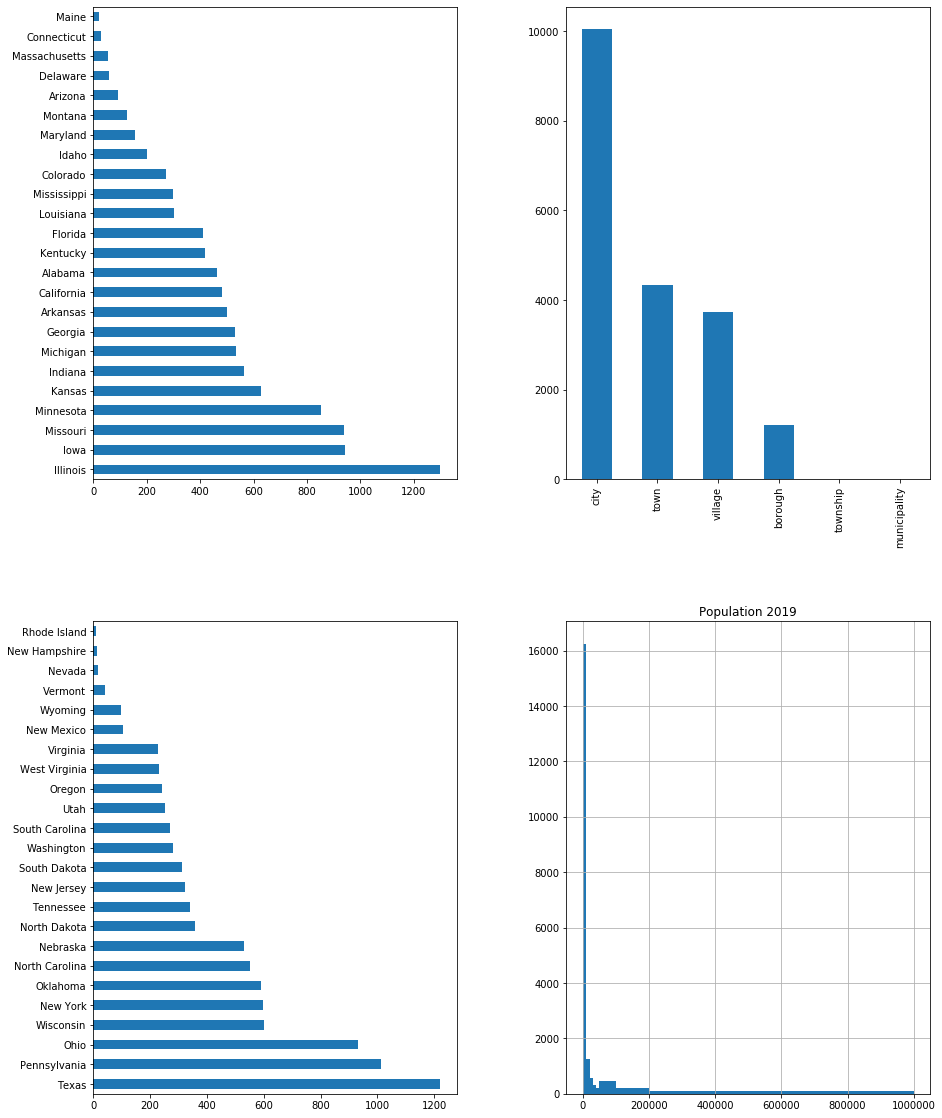

In [32]:
city_df = all_cities_df[:]

# Drop non-contiguous states and D.C.
city_df = city_df[city_df['State'] != 'Hawaii']
city_df = city_df[city_df['State'] != 'Alaska']
city_df = city_df[city_df['State'] != 'District of Columbia']

# check there are 48 left
print(len(city_df['State'].unique()))

# analyze city distribution
city_half1 = city_df['State'].unique().tolist()[0:24]
city_half2 = city_df['State'].unique().tolist()[24:48]

def in_half1(state):
    if state in city_half1:
        return True
    return False

def in_half2(state):
    if state in city_half2:
        return True
    return False

def visualize_cities(df):
    fig, axes = plt.subplots(2,2)
    fig.set_figheight(20)
    fig.set_figwidth(15)

    keep_idx1 = df['State'].apply(in_half1)
    keep_idx2 = df['State'].apply(in_half2)

    df[keep_idx1]['State'].value_counts().plot(kind='barh', ax=axes[0,0])
    df['City Type'].value_counts().plot(kind='bar', ax=axes[0,1])
    df[keep_idx2]['State'].value_counts().plot(kind='barh', ax=axes[1,0])
    df.hist('Population 2019', bins=[0,10000,20000,30000,40000,50000,100000,200000,1000000], ax=axes[1,1])
    
visualize_cities(city_df)

(1833, 5)


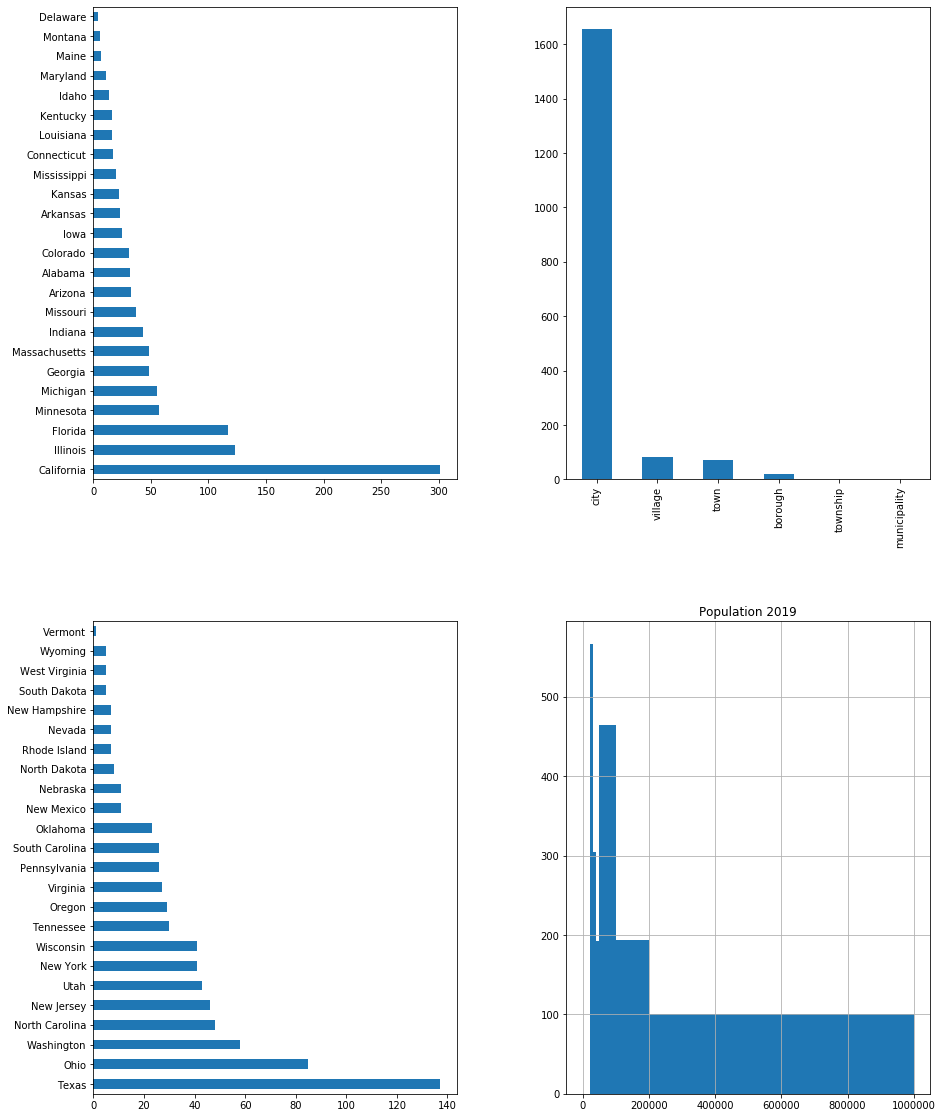

In [33]:
# drop cities with population < 20,000 ppl
min_value = 20000
drop_index = city_df['Population 2019'] > min_value
subset_df = city_df[drop_index].copy()

subset_df.to_csv('./subset20.csv')
print(subset_df.shape)
visualize_cities(subset_df)

<h4>Get the latitude and longitude coordinates for each of the remaining cities.</h4>
<ul>
    <li>It should take approximately 30 minutes to finish.</li>
    <li>Add the coordinates to the dataset from above and save.</li>
</ul>

In [52]:
subset_df.reset_index(inplace=True)
subset_df.drop(columns=['index'], inplace=True)
# Harvest the latitude and longitude values for each city.
latitudes = [0]*subset_df.shape[0]
longitudes = [0]*subset_df.shape[0]
subset_df.head()

,City Name,State,City Type,Population 2019,Growth (% since 2010),Latitude,Longitude
0,Alabaster,Alabama,city,33487,1.072992,32.535699,-85.486778
1,Albertville,Alabama,city,21711,1.024297,33.323493,-86.919183
2,Anniston,Alabama,city,21287,0.928266,34.799810,-87.677251
3,Athens,Alabama,city,27366,1.244248,33.481719,-86.745001
4,Auburn,Alabama,city,66259,1.231923,33.583652,-85.942452


In [61]:
for k in range(1405,len(subset_df['City Name'])):
    
    city = subset_df['City Name'].iloc[k]
    state_name = subset_df['State'].iloc[k]
    city_name = city + ", " + state_name
    
    print("%5d of %5d : %s" %(k,len(subset_df['City Name']),city_name))
    try:
        geolocator = Nominatim(user_agent="my_explorer")
        location = geolocator.geocode(city_name)
    except:
        print("Error comminucating with geo-service.")
        break
    
    try:
        latitudes[k] = location.latitude
        longitudes[k] = location.longitude
    except:
        print("No coordinates returned")
        latitudes[k] = 0
        longitudes[k] = 0
    
    time.sleep(1)
    
temp_df = pd.DataFrame(data={'Latitude':latitudes,'Longitude':longitudes})
temp_df.to_csv('./subset20_coord.csv')

 1405 of  1833 : Klamath Falls, Oregon
 1406 of  1833 : Lake Oswego, Oregon
 1407 of  1833 : McMinnville, Oregon
 1408 of  1833 : Medford, Oregon
 1409 of  1833 : Milwaukie, Oregon
 1410 of  1833 : Newberg, Oregon
 1411 of  1833 : Oregon City, Oregon
 1412 of  1833 : Portland, Oregon
 1413 of  1833 : Redmond, Oregon
 1414 of  1833 : Roseburg, Oregon
 1415 of  1833 : Salem, Oregon
 1416 of  1833 : Springfield, Oregon
 1417 of  1833 : Tigard, Oregon
 1418 of  1833 : Tualatin, Oregon
 1419 of  1833 : West Linn, Oregon
 1420 of  1833 : Wilsonville, Oregon
 1421 of  1833 : Woodburn, Oregon
 1422 of  1833 : Allentown, Pennsylvania
 1423 of  1833 : Altoona, Pennsylvania
 1424 of  1833 : Bethel Park, Pennsylvania
 1425 of  1833 : Bethlehem, Pennsylvania
 1426 of  1833 : Chambersburg, Pennsylvania
 1427 of  1833 : Chester, Pennsylvania
 1428 of  1833 : Easton, Pennsylvania
 1429 of  1833 : Erie, Pennsylvania
 1430 of  1833 : Harrisburg, Pennsylvania
 1431 of  1833 : Hazleton, Pennsylvania
 1432

 1629 of  1833 : San Juan, Texas
 1630 of  1833 : San Marcos, Texas
 1631 of  1833 : Schertz, Texas
 1632 of  1833 : Seguin, Texas
 1633 of  1833 : Sherman, Texas
 1634 of  1833 : Socorro, Texas
 1635 of  1833 : Southlake, Texas
 1636 of  1833 : Stephenville, Texas
 1637 of  1833 : Sugar Land, Texas
 1638 of  1833 : Temple, Texas
 1639 of  1833 : Texarkana, Texas
 1640 of  1833 : Texas City, Texas
 1641 of  1833 : The Colony, Texas
 1642 of  1833 : Tyler, Texas
 1643 of  1833 : Universal City, Texas
 1644 of  1833 : University Park, Texas
 1645 of  1833 : Victoria, Texas
 1646 of  1833 : Waco, Texas
 1647 of  1833 : Watauga, Texas
 1648 of  1833 : Waxahachie, Texas
 1649 of  1833 : Weatherford, Texas
 1650 of  1833 : Weslaco, Texas
 1651 of  1833 : Wichita Falls, Texas
 1652 of  1833 : Wylie, Texas
 1653 of  1833 : American Fork, Utah
 1654 of  1833 : Bountiful, Utah
 1655 of  1833 : Cedar City, Utah
 1656 of  1833 : Clearfield, Utah
 1657 of  1833 : Clinton, Utah
 1658 of  1833 : Cott

In [62]:
print(subset_df.shape)
print(temp_df.shape)

subset_df['Latitude'] = temp_df['Latitude']
subset_df['Longitude'] = temp_df['Longitude']
print(subset_df.shape)

subset_df.to_csv('./subset20.csv')
subset_df.head()

(1833, 7)
(1833, 2)
(1833, 7)


,City Name,State,City Type,Population 2019,Growth (% since 2010),Latitude,Longitude
0,Alabaster,Alabama,city,33487,1.072992,33.244281,-86.816377
1,Albertville,Alabama,city,21711,1.024297,34.267594,-86.208867
2,Anniston,Alabama,city,21287,0.928266,33.695381,-85.839842
3,Athens,Alabama,city,27366,1.244248,34.828383,-86.917134
4,Auburn,Alabama,city,66259,1.231923,32.535699,-85.486778


<h4>Visualize and adjust the data set, as necessary.</h4>
<ul>
    <li>Use folium to visualize the distribution across the US.</li>
    <li>Create a choropleth map to visualize how your data shows the concentration of the us population using figures from 2019.</li>
</ul>

In [67]:
# create map of US using latitude and longitude values for the center of the contiguous us
#39°50′N 98°35′W
us_latitude = 39.50
us_longitude = -98.35

map_us = folium.Map(location=[us_latitude, us_longitude], zoom_start=3)

# add markers to map
def create_map(df):
    for lat, lng, city, state in zip(df['Latitude'], df['Longitude'], df['City Name'], df['State']):
        label = '{}, {}, {}, {}'.format(city, state, lat, lng)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_us)  
    return map_us
    
map = create_map(subset_df)
map

In [68]:
# fix Lebanon, Ohio
# actual coordinates: 39.4353° N, 84.2030° W
lats = subset_df['Latitude'].copy()
lons = subset_df['Longitude'].copy()

for k in range(subset_df.shape[0]):
    if (subset_df['City Name'][k] == 'Lebanon' and subset_df['State'][k] == 'Ohio'):
        lats[k]=39.4353
        lons[k]=-84.2030
        print('replaced')

subset_df['Latitude'] = lats
subset_df['Longitude'] = lons

# remove zero latitude and longitude rows
drop_index = []

for k in range(subset_df.shape[0]):
    if (subset_df['Latitude'][k] == 0 and subset_df['Longitude'][k] == 0):
        drop_index.append(k)
        print('indexed')
        
subset_df.drop(drop_index, inplace=True)

subset_df.to_csv('./data/subset20.csv')

replaced
indexed
indexed
indexed
indexed


<h2>Load and process the secondary dataset.</h2>
<ul>
    <li>Population data for each state. More info <a href='https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/nst-est2019-01.xlsx'>here</a>.</li>
    <li>Election results by each state for the last 100 years. More info <a href='https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state'>here</a></li>
    <li>Health data for each state. More info <a href='https://www.cdc.gov/nchs/fastats/state-and-territorial-data.htm'>here</a>.</li>
    <li>Unemployment rate for each state. More info <a href='https://www.bls.gov/web/laus/laumstrk.htm'>here</a>.</li>
</ul>

<h4>State Population Figures</h4>

In [69]:
state_pop_URL = 'https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/nst-est2019-01.xlsx'
state_pop_df = pd.read_excel(state_pop_URL, skiprows=3)

state_pop_df.drop(columns=['Census', 'Estimates Base'], inplace=True)
state_pop_df.rename(columns={'Unnamed: 0':'State'}, inplace=True)
state_pop_df['Growth (% since 2010)'] = state_pop_df[2019] / state_pop_df[2010]

def remove_nonstates(df):
    for k in range(len(state_pop_df['State'])):
        name = state_pop_df['State'][k]
        if str(name)[0] == '.':
            replace = name[1:]
            state_pop_df['State'] = state_pop_df['State'].replace(name,replace)
        else:
            state_pop_df.drop([k], axis=0, inplace=True)
    return df

state_pop_df = remove_nonstates(state_pop_df)
state_pop_df.reset_index(inplace=True)
state_pop_df.drop(columns=['index'], inplace=True)

for k in range(2010,2019,1):
    state_pop_df.drop(columns=[k], inplace=True)

state_pop_df.rename(columns={2019:'Population 2019'}, inplace=True)
state_pop_df['Population 2019'] = state_pop_df['Population 2019'].astype('int32')

def is_drop_state(state):
    if (state == 'District of Columbia' or state == 'Alaska' or state == 'Hawaii'):
        return True
    return False

d_index = state_pop_df[state_pop_df['State'].apply(is_drop_state)].index
state_pop_df.drop(d_index, axis=0, inplace=True)

state_pop_df.reset_index(inplace=True)
state_pop_df.drop(columns=['index'], inplace=True)
state_pop_df.sort_values(by=['State'], inplace=True)
state_pop_df.rename(columns={'Population 2019':'State Population 2019','Growth (% since 2010)':'State Growth (% since 2010)'}, inplace=True)

state_pop_df.to_csv('./data/state_pop_data.csv')    
print(state_pop_df.shape)
state_pop_df.head()

(48, 3)


,State,State Population 2019,State Growth (% since 2010)
0,Alabama,4903185,1.024605
1,Arizona,7278717,1.136026
2,Arkansas,3017804,1.032800
3,California,39512223,1.058755
4,Colorado,5758736,1.140943


<h4>State Election Results</h4>

In [70]:
state_elections_URL = 'https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state'
state_elections_df = pd.read_html(state_elections_URL)[0]

for i in range(state_elections_df.shape[1]):
    col = state_elections_df.iloc[0][i]
    state_elections_df.rename(columns={i:col}, inplace=True)

state_elections_df.drop([0], axis=0, inplace=True)

state_elections_df.dropna(subset=['State'], inplace=True)

column_numbers = [x for x in range(state_elections_df.shape[1])]
column_numbers.remove(state_elections_df.shape[1]-1)
state_elections_df = state_elections_df.iloc[:, column_numbers]

state_elections_df = state_elections_df.loc[:, state_elections_df.columns.notnull()]
state_elections_df = state_elections_df.loc[state_elections_df['State'] != 'State']

drop_cols = []
for j in range(1,len(state_elections_df.columns)):
    name = state_elections_df.columns[j]
    year = name[0:4]
    if int(year) < 2000:
        drop_cols.append(name)
    else:
        state_elections_df.rename(columns = {name:year},inplace=True)

state_elections_df.drop(columns = drop_cols, inplace = True)
state_elections_df.reset_index(inplace=True)
state_elections_df.drop(columns=['index'], inplace=True)

for k in range(1,len(state_elections_df.columns)):
    oldName = state_elections_df.columns[k]
    newName = 'Election ' + str(oldName)
    state_elections_df.rename(columns={oldName:newName}, inplace=True)

def is_drop_state(state):
    if (state == 'District of Columbia' or state == 'D.C.' or state == 'Alaska' or state == 'Hawaii'):
        return True
    return False

d_index = state_elections_df[state_elections_df['State'].apply(is_drop_state)].index
state_elections_df.drop(d_index, axis=0, inplace=True)

state_elections_df.reset_index(inplace=True)
state_elections_df.drop(columns=['index'], inplace=True)
state_elections_df.sort_values(by=['State'], inplace=True)

#one-hot encoding of election results
state_elections_df.set_index('State', inplace=True)
state_elections_df = pd.get_dummies(state_elections_df)
state_elections_df.reset_index(inplace=True)

for col in state_elections_df.columns.tolist():
    if 'Election' in col:
        state_elections_df.rename(columns={col:"State "+col}, inplace=True)

state_elections_df.to_csv('./data/state_elections_data.csv')
print(state_elections_df.shape)
state_elections_df.head()

(48, 11)


,State,State Election 2000_D,State Election 2000_R,State Election 2004_D,State Election 2004_R,State Election 2008_D,State Election 2008_R,State Election 2012_D,State Election 2012_R,State Election 2016_D,State Election 2016_R
0,Alabama,0,1,0,1,0,1,0,1,0,1
1,Arizona,0,1,0,1,0,1,0,1,0,1
2,Arkansas,0,1,0,1,0,1,0,1,0,1
3,California,1,0,1,0,1,0,1,0,1,0
4,Colorado,0,1,0,1,1,0,1,0,1,0


<h4>State Health Statistics</h4>
<ul>
    <li>The births and fertility data are from 2018.</li>
    <li>The deaths and death rate are from 2017.</li>
</ul>

In [71]:
state_health_URL = 'https://www.cdc.gov/nchs/fastats/state-and-territorial-data.htm'
state_health_df = pd.read_html(state_health_URL)[0]

state_health_df.drop(list(range(51,58)), axis=0, inplace=True)
state_health_df.rename(columns={'State/Territory':'State'}, inplace=True)

def is_drop_state(state):
    if (state == 'District of Columbia' or state == 'D.C.' or state == 'Alaska' or state == 'Hawaii'):
        return True
    return False

d_index = state_health_df[state_health_df['State'].apply(is_drop_state)].index
state_health_df.drop(d_index, axis=0, inplace=True)

state_health_df.reset_index(inplace=True)
state_health_df.drop(columns=['index'], inplace=True)
state_health_df.sort_values(by=['State'], inplace=True)

state_health_df.drop(columns=['Births','Deaths'], inplace=True)
column_dict = {
    'Fertility Rate':'State Birth Rate',
    'Death Rate':'State Death Rate'
}
state_health_df.rename(columns=column_dict, inplace=True)

state_health_df.to_csv('./data/state_health_data.csv')
print(state_health_df.shape)
state_health_df.head()

(48, 3)


,State,State Birth Rate,State Death Rate
0,Alabama,60.9,1092.1
1,Arizona,58.6,823.2
2,Arkansas,64.0,1084.7
3,California,56.2,678.3
4,Colorado,54.1,678.8


<h4>State Unemployment Rate</h4>
<ul>
    <li>Data is from April 2020.</li>
    <li>Data is shown as a percentage of the population total.</li>
</ul>

In [72]:
state_unemp_URL = 'https://www.bls.gov/web/laus/laumstrk.htm'
state_unemp_df = pd.read_html(state_unemp_URL)[0]

state_unemp_df.drop(columns=['Rank'], inplace=True)
state_unemp_df.rename(columns={'April 2020(p)rate':'Unemployment Rate'}, inplace=True)
state_unemp_df.drop(list(range(51,54)), axis=0, inplace=True)
state_unemp_df.sort_values(by=['State'], inplace=True)
state_unemp_df.reset_index(inplace=True)
state_unemp_df.drop(columns=['index'], inplace=True)

def is_drop_state(state):
    if (state == 'District of Columbia' or state == 'D.C.' or state == 'Alaska' or state == 'Hawaii'):
        return True
    return False

d_index = state_unemp_df[state_unemp_df['State'].apply(is_drop_state)].index
state_unemp_df.drop(d_index, axis=0, inplace=True)

state_unemp_df.reset_index(inplace=True)
state_unemp_df.drop(columns=['index'], inplace=True)
state_unemp_df.sort_values(by=['State'], inplace=True)
state_unemp_df.rename(columns={'Unemployment Rate':'State Unemployment'}, inplace=True)

state_unemp_df.to_csv('./data/state_unemp_data.csv')
print(state_unemp_df.shape)
state_unemp_df.head()

(48, 2)


,State,State Unemployment
0,Alabama,12.9
1,Arizona,12.6
2,Arkansas,10.2
3,California,15.5
4,Colorado,11.3


<h4>Combine all tables.</h4>
<ul>
    <li>Combine all state-level data into one frame.</li>
    <li>Merge state-level data with city-level data.</li>
    <li>Set the index to be the City Name, State.</li>
</ul>

In [74]:
state_data_df = pd.merge(state_pop_df, state_health_df, how='inner', on=['State','State'])
state_data_df = pd.merge(state_data_df, state_elections_df, how='inner', on=['State','State'])
state_data_df = pd.merge(state_data_df, state_unemp_df, how='inner', on=['State','State'])

state_data_df.to_csv('./data/state_data.csv')
print(state_data_df.shape)
state_data_df.head()

(48, 16)


,State,State Population 2019,State Growth (% since 2010),State Birth Rate,State Death Rate,State Election 2000_D,State Election 2000_R,State Election 2004_D,State Election 2004_R,State Election 2008_D,State Election 2008_R,State Election 2012_D,State Election 2012_R,State Election 2016_D,State Election 2016_R,State Unemployment
0,Alabama,4903185,1.024605,60.9,1092.1,0,1,0,1,0,1,0,1,0,1,12.9
1,Arizona,7278717,1.136026,58.6,823.2,0,1,0,1,0,1,0,1,0,1,12.6
2,Arkansas,3017804,1.032800,64.0,1084.7,0,1,0,1,0,1,0,1,0,1,10.2
3,California,39512223,1.058755,56.2,678.3,1,0,1,0,1,0,1,0,1,0,15.5
4,Colorado,5758736,1.140943,54.1,678.8,0,1,0,1,1,0,1,0,1,0,11.3


In [75]:
subset20_df = pd.read_csv('./data/subset20.csv')
subset20_df.drop(columns=['Unnamed: 0'], inplace=True)

l_names = [0]*subset20_df.shape[0]
for j in range(len(subset20_df['City Name'])):
    c_name = subset20_df['City Name'][j]
    s_name = subset20_df['State'][j]
    l_names[j] = c_name + ", " + s_name
subset20_df['Location'] = l_names
subset20_df.set_index('Location',inplace=True)
subset20_df.to_csv('./data/subset20.csv')
subset20_df.head()

,City Name,State,City Type,Population 2019,Growth (% since 2010),Latitude,Longitude
Location,,,,,,,
"Alabaster, Alabama",Alabaster,Alabama,city,33487,1.072992,33.244281,-86.816377
"Albertville, Alabama",Albertville,Alabama,city,21711,1.024297,34.267594,-86.208867
"Anniston, Alabama",Anniston,Alabama,city,21287,0.928266,33.695381,-85.839842
"Athens, Alabama",Athens,Alabama,city,27366,1.244248,34.828383,-86.917134
"Auburn, Alabama",Auburn,Alabama,city,66259,1.231923,32.535699,-85.486778


<h2>Acquire Foursquare Data.</h2>
<ul>
    <li>Define foursquare credentials.</li>
    <li>For each city, get the following features from Foursquare:</li>
    <ul>
        <li>Radius of 5000 meters.</li>
        <li>Return the top 100 venues.</li>
    </ul>
</ul>

In [8]:
CLIENT_ID = 'HL3GC4OJTZINFKFIYZEEC535KNHZ3A3DFTQRWCZ34MO2EXUK' # your Foursquare ID
CLIENT_SECRET = 'OURWVENPDO3UAUUFLCYGJLFOM2MRLGAMATSNXTR1WJMQKYEY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HL3GC4OJTZINFKFIYZEEC535KNHZ3A3DFTQRWCZ34MO2EXUK
CLIENT_SECRET:OURWVENPDO3UAUUFLCYGJLFOM2MRLGAMATSNXTR1WJMQKYEY


<h5>This is how you can get the top 100 venues that are in a specific location, within a certain radius.</h5>

In [ ]:
import sys
import math
from random import seed
from random import random

radius=5000
LIMIT = 100

k = math.floor(random()*1800)
lat = subset20_df['Latitude'][k]
lng = subset20_df['Longitude'][k]
city = subset20_df['City Name'][k]
print("Searching : %s : %4f, %4f" %(city,lat,lng))

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
results = requests.get(url).json()


# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.shape)
nearby_venues.head()

<h4>Get top 100 venues for ALL cities.</h4>

In [10]:
radius = 5000
limit = 100

# do the same for ALL cities
def getVenues(names, latitudes, longitudes, radius=5000):
    
    iter = 0
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("%4d of %4d : %s" %(iter,len(names)-1,name))
        iter=iter+1
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print("Couldn't get a response.")
        
        


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
#split into 2 halfs 1-915 and others 
subset20 = pd.read_csv('./data/subset20.csv')
subset20_half1_df = subset20[:500][:].copy()
subset20_half2_df = subset20[500:1200][:].copy()
subset20_half3_df = subset20[1200:][:].copy()
subset20.head()

,Location,City Name,State,City Type,Population 2019,Growth (% since 2010),Latitude,Longitude
0,"Alabaster, Alabama",Alabaster,Alabama,city,33487,1.072992,33.244281,-86.816377
1,"Albertville, Alabama",Albertville,Alabama,city,21711,1.024297,34.267594,-86.208867
2,"Anniston, Alabama",Anniston,Alabama,city,21287,0.928266,33.695381,-85.839842
3,"Athens, Alabama",Athens,Alabama,city,27366,1.244248,34.828383,-86.917134
4,"Auburn, Alabama",Auburn,Alabama,city,66259,1.231923,32.535699,-85.486778


In [12]:
us_venues_half1 = getVenues(names=subset20_half1_df['Location'], 
                            latitudes=subset20_half1_df['Latitude'], 
                            longitudes=subset20_half1_df['Longitude'])

us_venues_half1.to_csv('./data/us_venues_half1.csv')

   0 of  499 : Alabaster, Alabama
   1 of  499 : Albertville, Alabama
   2 of  499 : Anniston, Alabama
   3 of  499 : Athens, Alabama
   4 of  499 : Auburn, Alabama
   5 of  499 : Bessemer, Alabama
   6 of  499 : Birmingham, Alabama
   7 of  499 : Daphne, Alabama
   8 of  499 : Decatur, Alabama
   9 of  499 : Dothan, Alabama
  10 of  499 : Enterprise, Alabama
  11 of  499 : Fairhope, Alabama
  12 of  499 : Florence, Alabama
  13 of  499 : Foley, Alabama
  14 of  499 : Gadsden, Alabama
  15 of  499 : Homewood, Alabama
  16 of  499 : Hoover, Alabama
  17 of  499 : Huntsville, Alabama
  18 of  499 : Madison, Alabama
  19 of  499 : Mobile, Alabama
  20 of  499 : Montgomery, Alabama
  21 of  499 : Mountain Brook, Alabama
  22 of  499 : Northport, Alabama
  23 of  499 : Opelika, Alabama
  24 of  499 : Oxford, Alabama
  25 of  499 : Pelham, Alabama
  26 of  499 : Phenix City, Alabama
  27 of  499 : Prattville, Alabama
  28 of  499 : Prichard, Alabama
  29 of  499 : Trussville, Alabama
  30 of

 229 of  499 : Los Angeles, California
 230 of  499 : Los Banos, California
 231 of  499 : Los Gatos, California
 232 of  499 : Lynwood, California
 233 of  499 : Madera, California
 234 of  499 : Manhattan Beach, California
 235 of  499 : Manteca, California
 236 of  499 : Marina, California
 237 of  499 : Martinez, California
 238 of  499 : Maywood, California
 239 of  499 : Menifee, California
 240 of  499 : Menlo Park, California
 241 of  499 : Merced, California
 242 of  499 : Millbrae, California
 243 of  499 : Milpitas, California
 244 of  499 : Mission Viejo, California
 245 of  499 : Modesto, California
 246 of  499 : Monrovia, California
 247 of  499 : Montclair, California
 248 of  499 : Montebello, California
 249 of  499 : Monterey, California
 250 of  499 : Monterey Park, California
 251 of  499 : Moorpark, California
 252 of  499 : Moreno Valley, California
 253 of  499 : Morgan Hill, California
 254 of  499 : Mountain View, California
 255 of  499 : Murrieta, California

 447 of  499 : Bonita Springs, Florida
 448 of  499 : Boynton Beach, Florida
 449 of  499 : Bradenton, Florida
 450 of  499 : Cape Coral, Florida
 451 of  499 : Casselberry, Florida
 452 of  499 : Clearwater, Florida
 453 of  499 : Clermont, Florida
 454 of  499 : Coconut Creek, Florida
 455 of  499 : Cooper City, Florida
 456 of  499 : Coral Gables, Florida
 457 of  499 : Coral Springs, Florida
 458 of  499 : Crestview, Florida
 459 of  499 : Cutler Bay, Florida
 460 of  499 : Dania Beach, Florida
 461 of  499 : Davie, Florida
 462 of  499 : Daytona Beach, Florida
 463 of  499 : DeBary, Florida
 464 of  499 : Deerfield Beach, Florida
 465 of  499 : DeLand, Florida
 466 of  499 : Delray Beach, Florida
 467 of  499 : Deltona, Florida
 468 of  499 : Doral, Florida
 469 of  499 : Dunedin, Florida
 470 of  499 : Edgewater, Florida
 471 of  499 : Estero, Florida
 472 of  499 : Eustis, Florida
 473 of  499 : Fort Lauderdale, Florida
 474 of  499 : Fort Myers, Florida
 475 of  499 : Fort Pier

In [13]:
print(us_venues_half1.shape)
us_venues_half1.head()

(42408, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Alabaster, Alabama",33.244281,-86.816377,Champy's Famous Fried Chicken,33.235264,-86.822617,Fried Chicken Joint
1,"Alabaster, Alabama",33.244281,-86.816377,Buffalo Wild Wings,33.238706,-86.801395,Wings Joint
2,"Alabaster, Alabama",33.244281,-86.816377,K&J's Elegant Pastries,33.241643,-86.816845,Bakery
3,"Alabaster, Alabama",33.244281,-86.816377,Chubbfathers,33.257848,-86.813603,Seafood Restaurant
4,"Alabaster, Alabama",33.244281,-86.816377,Amstar Stadium 14,33.237861,-86.799710,Multiplex


In [14]:
us_venues_half2 = getVenues(names=subset20_half2_df['Location'],
                     latitudes=subset20_half2_df['Latitude'],
                     longitudes=subset20_half2_df['Longitude'])

us_venues_half2.to_csv('./data/us_venues_half2.csv')

   0 of  699 : Miami Beach, Florida
   1 of  699 : Miami Gardens, Florida
Couldn't get a response.
   2 of  699 : Miami Lakes, Florida
Couldn't get a response.
   3 of  699 : Miramar, Florida
   4 of  699 : Naples, Florida
Couldn't get a response.
   5 of  699 : New Smyrna Beach, Florida
   6 of  699 : North Lauderdale, Florida
   7 of  699 : North Miami, Florida
   8 of  699 : North Miami Beach, Florida
Couldn't get a response.
   9 of  699 : North Port, Florida
  10 of  699 : Oakland Park, Florida
  11 of  699 : Ocala, Florida
  12 of  699 : Ocoee, Florida
  13 of  699 : Orlando, Florida
  14 of  699 : Ormond Beach, Florida
  15 of  699 : Oviedo, Florida
  16 of  699 : Palm Bay, Florida
Couldn't get a response.
  17 of  699 : Palm Beach Gardens, Florida
  18 of  699 : Palm Coast, Florida
  19 of  699 : Palmetto Bay, Florida
  20 of  699 : Palm Springs, Florida
  21 of  699 : Panama City, Florida
  22 of  699 : Parkland, Florida
  23 of  699 : Pembroke Pines, Florida
  24 of  699 : Pe

 228 of  699 : Streamwood, Illinois
 229 of  699 : Tinley Park, Illinois
 230 of  699 : Urbana, Illinois
 231 of  699 : Vernon Hills, Illinois
 232 of  699 : Villa Park, Illinois
 233 of  699 : Waukegan, Illinois
 234 of  699 : West Chicago, Illinois
 235 of  699 : Westmont, Illinois
 236 of  699 : Wheaton, Illinois
 237 of  699 : Wheeling, Illinois
 238 of  699 : Wilmette, Illinois
 239 of  699 : Woodridge, Illinois
 240 of  699 : Woodstock, Illinois
 241 of  699 : Yorkville, Illinois
 242 of  699 : Zion, Illinois
 243 of  699 : Anderson, Indiana
 244 of  699 : Bloomington, Indiana
 245 of  699 : Brownsburg, Indiana
 246 of  699 : Carmel, Indiana
 247 of  699 : Clarksville, Indiana
 248 of  699 : Columbus, Indiana
 249 of  699 : Crown Point, Indiana
 250 of  699 : East Chicago, Indiana
 251 of  699 : Elkhart, Indiana
 252 of  699 : Evansville, Indiana
 253 of  699 : Fishers, Indiana
 254 of  699 : Fort Wayne, Indiana
 255 of  699 : Franklin, Indiana
 256 of  699 : Gary, Indiana
 257 o

 457 of  699 : Marquette, Michigan
 458 of  699 : Midland, Michigan
 459 of  699 : Mount Pleasant, Michigan
 460 of  699 : Muskegon, Michigan
 461 of  699 : Norton Shores, Michigan
 462 of  699 : Novi, Michigan
 463 of  699 : Oak Park, Michigan
 464 of  699 : Pontiac, Michigan
 465 of  699 : Portage, Michigan
 466 of  699 : Port Huron, Michigan
 467 of  699 : Rochester Hills, Michigan
 468 of  699 : Romulus, Michigan
 469 of  699 : Roseville, Michigan
 470 of  699 : Royal Oak, Michigan
 471 of  699 : Saginaw, Michigan
 472 of  699 : St. Clair Shores, Michigan
 473 of  699 : Southfield, Michigan
 474 of  699 : Southgate, Michigan
 475 of  699 : Sterling Heights, Michigan
 476 of  699 : Taylor, Michigan
 477 of  699 : Troy, Michigan
 478 of  699 : Walker, Michigan
 479 of  699 : Warren, Michigan
 480 of  699 : Westland, Michigan
 481 of  699 : Wyandotte, Michigan
 482 of  699 : Wyoming, Michigan
 483 of  699 : Ypsilanti, Michigan
 484 of  699 : Andover, Minnesota
 485 of  699 : Apple Val

 684 of  699 : Roswell, New Mexico
 685 of  699 : Santa Fe, New Mexico
 686 of  699 : Albany, New York
 687 of  699 : Auburn, New York
 688 of  699 : Binghamton, New York
 689 of  699 : Buffalo, New York
 690 of  699 : Elmira, New York
 691 of  699 : Freeport, New York
 692 of  699 : Garden City, New York
 693 of  699 : Glen Cove, New York
 694 of  699 : Harrison, New York
 695 of  699 : Hempstead, New York
 696 of  699 : Ithaca, New York
 697 of  699 : Jamestown, New York
 698 of  699 : Kingston, New York
 699 of  699 : Kiryas Joel, New York


In [15]:
print(us_venues_half2.shape)
us_venues_half2.head()

(61063, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Miami Beach, Florida",25.79292,-80.135301,Art Basel,25.794563,-80.134187,Art Gallery
1,"Miami Beach, Florida",25.79292,-80.135301,The Fillmore Miami Beach at The Jackie Gleason...,25.792886,-80.133284,Performing Arts Venue
2,"Miami Beach, Florida",25.79292,-80.135301,Lincoln Road Mall,25.790671,-80.135359,Shopping Mall
3,"Miami Beach, Florida",25.79292,-80.135301,SoundScape Park at the New World Center,25.791822,-80.132611,Performing Arts Venue
4,"Miami Beach, Florida",25.79292,-80.135301,Lincoln Road,25.790679,-80.132704,Road


In [16]:
us_venues_half3 = getVenues(names=subset20_half3_df['Location'],
                     latitudes=subset20_half3_df['Latitude'],
                     longitudes=subset20_half3_df['Longitude'])

us_venues_half3.to_csv('./data/us_venues_half3.csv')

   0 of  628 : Lindenhurst, New York
   1 of  628 : Lockport, New York
Couldn't get a response.
   2 of  628 : Long Beach, New York
   3 of  628 : Middletown, New York
Couldn't get a response.
   4 of  628 : Mount Vernon, New York
   5 of  628 : Newburgh, New York
   6 of  628 : New Rochelle, New York
   7 of  628 : New York, New York
   8 of  628 : Niagara Falls, New York
   9 of  628 : North Tonawanda, New York
  10 of  628 : Ossining, New York
  11 of  628 : Peekskill, New York
  12 of  628 : Port Chester, New York
  13 of  628 : Poughkeepsie, New York
  14 of  628 : Rochester, New York
  15 of  628 : Rockville Centre, New York
  16 of  628 : Rome, New York
  17 of  628 : Saratoga Springs, New York
  18 of  628 : Schenectady, New York
  19 of  628 : Spring Valley, New York
  20 of  628 : Syracuse, New York
  21 of  628 : Troy, New York
  22 of  628 : Utica, New York
  23 of  628 : Valley Stream, New York
  24 of  628 : Watertown, New York
  25 of  628 : White Plains, New York
  26 o

 234 of  628 : Norristown, Pennsylvania
 235 of  628 : Philadelphia, Pennsylvania
 236 of  628 : Pittsburgh, Pennsylvania
 237 of  628 : Plum, Pennsylvania
 238 of  628 : Pottstown, Pennsylvania
 239 of  628 : Reading, Pennsylvania
 240 of  628 : Scranton, Pennsylvania
 241 of  628 : State College, Pennsylvania
 242 of  628 : West Chester, Pennsylvania
 243 of  628 : Wilkes-Barre, Pennsylvania
 244 of  628 : Williamsport, Pennsylvania
 245 of  628 : York, Pennsylvania
Couldn't get a response.
 246 of  628 : Cranston, Rhode Island
 247 of  628 : East Providence, Rhode Island
 248 of  628 : Newport, Rhode Island
 249 of  628 : Pawtucket, Rhode Island
 250 of  628 : Providence, Rhode Island
 251 of  628 : Warwick, Rhode Island
 252 of  628 : Woonsocket, Rhode Island
 253 of  628 : Aiken, South Carolina
 254 of  628 : Anderson, South Carolina
 255 of  628 : Bluffton, South Carolina
 256 of  628 : Charleston, South Carolina
 257 of  628 : Columbia, South Carolina
 258 of  628 : Conway, Sout

 472 of  628 : Orem, Utah
 473 of  628 : Payson, Utah
 474 of  628 : Pleasant Grove, Utah
 475 of  628 : Provo, Utah
 476 of  628 : Riverton, Utah
 477 of  628 : Roy, Utah
 478 of  628 : St. George, Utah
 479 of  628 : Salt Lake City, Utah
 480 of  628 : Sandy, Utah
 481 of  628 : Saratoga Springs, Utah
 482 of  628 : South Jordan, Utah
 483 of  628 : South Salt Lake, Utah
 484 of  628 : Spanish Fork, Utah
 485 of  628 : Springville, Utah
 486 of  628 : Syracuse, Utah
 487 of  628 : Taylorsville, Utah
 488 of  628 : Tooele, Utah
 489 of  628 : Washington, Utah
 490 of  628 : West Jordan, Utah
 491 of  628 : West Valley City, Utah
 492 of  628 : Burlington, Vermont
 493 of  628 : Alexandria, Virginia
 494 of  628 : Blacksburg, Virginia
 495 of  628 : Charlottesville, Virginia
 496 of  628 : Chesapeake, Virginia
 497 of  628 : Christiansburg, Virginia
 498 of  628 : Danville, Virginia
 499 of  628 : Fairfax, Virginia
 500 of  628 : Fredericksburg, Virginia
 501 of  628 : Hampton, Virgini

In [18]:
print(us_venues_half3.shape)
us_venues_half3.head()

(52910, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Lindenhurst, New York",40.686767,-73.373455,Black Forest Bakery,40.687898,-73.374617,Bakery
1,"Lindenhurst, New York",40.686767,-73.373455,Kabuki Sushi,40.685700,-73.372410,Sushi Restaurant
2,"Lindenhurst, New York",40.686767,-73.373455,Villa Gaia,40.687133,-73.374234,Italian Restaurant
3,"Lindenhurst, New York",40.686767,-73.373455,Village Lanterne,40.687972,-73.374825,German Restaurant
4,"Lindenhurst, New York",40.686767,-73.373455,Wellwood Bagels,40.702325,-73.384208,Bagel Shop


In [25]:
# Stack the DataFrames on top of each other
us_venues_half1 = pd.read_csv('./data/us_venues_half1.csv')
us_venues_half1.drop(columns=['Unnamed: 0'], inplace=True)
us_venues_half2 = pd.read_csv('./data/us_venues_half2.csv')
us_venues_half2.drop(columns=['Unnamed: 0'], inplace=True)
us_venues_half3 = pd.read_csv('./data/us_venues_half3.csv')
us_venues_half3.drop(columns=['Unnamed: 0'], inplace=True)

us_venues = pd.concat([us_venues_half1, us_venues_half2]).reset_index()
us_venues = pd.concat([us_venues, us_venues_half3]).reset_index()
us_venues.drop(columns=['level_0', 'index'], inplace=True)
us_venues.rename(columns={'Neighborhood':'Location','Neighborhood Latitude':'City Latitude','Neighborhood Longitude':'City Longitude'}, inplace=True)

us_venues_df.to_csv('./data/us_venues.csv')
print(us_venues.shape)
us_venues.head()

(156381, 7)


,Location,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Alabaster, Alabama",33.244281,-86.816377,Champy's Famous Fried Chicken,33.235264,-86.822617,Fried Chicken Joint
1,"Alabaster, Alabama",33.244281,-86.816377,Buffalo Wild Wings,33.238706,-86.801395,Wings Joint
2,"Alabaster, Alabama",33.244281,-86.816377,K&J's Elegant Pastries,33.241643,-86.816845,Bakery
3,"Alabaster, Alabama",33.244281,-86.816377,Chubbfathers,33.257848,-86.813603,Seafood Restaurant
4,"Alabaster, Alabama",33.244281,-86.816377,Amstar Stadium 14,33.237861,-86.799710,Multiplex


In [31]:
# Check number of venues for each location
us_venues.groupby('Location').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Location,,,,,,
"Aberdeen, South Dakota",67,67,67,67,67,67
"Abilene, Texas",100,100,100,100,100,100
"Acworth, Georgia",100,100,100,100,100,100
"Addison, Illinois",100,100,100,100,100,100
"Adelanto, California",18,18,18,18,18,18
...,...,...,...,...,...,...
"Yukon, Oklahoma",90,90,90,90,90,90
"Yuma, Arizona",100,100,100,100,100,100
"Zanesville, Ohio",97,97,97,97,97,97


In [32]:
print('There are {} uniques categories.'.format(len(us_venues['Venue Category'].unique())))

There are 614 uniques categories.


In [33]:
# one-hot encoding
us_venues_onehot = pd.get_dummies(us_venues[['Venue Category']], prefix="", prefix_sep="")

# add location column back to dataframe
us_venues_onehot['Location'] = us_venues['Location']

# move neighborhood column to the first column
fixed_columns = [us_venues_onehot.columns[-1]] + list(us_venues_onehot.columns[:-1])
us_venues_onehot = us_venues_onehot[fixed_columns]

us_venues_onehot.to_csv('./data/us_venues_onehot.csv')
print(us_venues_onehot.shape)
us_venues_onehot.head()

(156381, 615)


,Location,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Alabaster, Alabama",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alabaster, Alabama",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,"Alabaster, Alabama",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Alabaster, Alabama",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Alabaster, Alabama",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
us_venues_grouped = us_venues_onehot.groupby('Location').sum().reset_index()

us_venues_grouped.to_csv('./data/us_venues_grouped.csv')
print(us_venues_grouped.shape)
us_venues_grouped.head()

(1787, 615)


,Location,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Aberdeen, South Dakota",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"Abilene, Texas",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,"Acworth, Georgia",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,"Addison, Illinois",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Adelanto, California",0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
us_venues_sorted = pd.DataFrame(columns=columns)
us_venues_sorted['Location'] = us_venues_grouped['Location']

for ind in np.arange(us_venues_grouped.shape[0]):
    us_venues_sorted.iloc[ind, 1:] = return_most_common_venues(us_venues_grouped.iloc[ind, :], num_top_venues)

us_venues_sorted.to_csv('./data/us_venues_sorted.csv')
print()    
us_venues_sorted.head()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aberdeen, South Dakota",Fast Food Restaurant,American Restaurant,Mexican Restaurant,Pizza Place,Italian Restaurant,Mobile Phone Shop,Sports Bar,Hardware Store,Hotel,Park
1,"Abilene, Texas",Mexican Restaurant,Grocery Store,Fast Food Restaurant,American Restaurant,Coffee Shop,Discount Store,Sandwich Place,Restaurant,Pharmacy,Burger Joint
2,"Acworth, Georgia",Park,Mexican Restaurant,American Restaurant,Sandwich Place,Pizza Place,Fast Food Restaurant,Grocery Store,BBQ Joint,Breakfast Spot,Coffee Shop
3,"Addison, Illinois",Mexican Restaurant,Pizza Place,Hot Dog Joint,Coffee Shop,Grocery Store,Bakery,Fast Food Restaurant,Breakfast Spot,Sandwich Place,Deli / Bodega
4,"Adelanto, California",Video Store,Airport,Burger Joint,Pizza Place,Department Store,Mexican Restaurant,Park,Farmers Market,Marijuana Dispensary,Discount Store


<h4>Combine all data into a single dataframe.</h4>
<ul>
    <li>Merge previous datset subset20 and states_data.</li>
    <li>Merge with Foursquare data.</li>
</ul>

In [37]:
us_venues_grouped = pd.read_csv('./data/us_venues_grouped.csv')
us_venues_grouped.drop(columns=['Unnamed: 0'], inplace=True)

us_venues_grouped['Total'] = us_venues_grouped.sum(axis=1)

cols = us_venues_grouped.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[1:-1]
us_venues_grouped = us_venues_grouped[cols]

us_venues_grouped.to_csv('./data/us_venues_grouped.csv')
print(us_venues_grouped.shape)
us_venues_grouped.head()

(1787, 616)


,Location,Total,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Aberdeen, South Dakota",67,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"Abilene, Texas",100,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,"Acworth, Georgia",100,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,"Addison, Illinois",100,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Adelanto, California",18,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [38]:
us_venues_grouped = pd.read_csv('./data/us_venues_grouped.csv')
us_venues_grouped.drop(columns=['Unnamed: 0'], inplace=True)

subset20_df = pd.read_csv('./data/subset20.csv')
#us_venues_grouped.drop(columns=['Unnamed: 0'], inplace=True)

state_data_df = pd.read_csv('./data/state_data.csv')
state_data_df.drop(columns=['Unnamed: 0'], inplace=True)

main_df = us_venues_grouped.copy()
main_df = pd.merge(main_df, subset20, how='inner', on=['Location','Location'])
cols = main_df.columns.tolist()
cols = cols[:1] + cols[-7:] + cols[1:-7]
main_df = main_df[cols]

main_df = pd.merge(main_df, state_data_df, how='inner', on=['State','State'])
main_df.sort_values(by=['State','City Name'], inplace=True)
main_df.reset_index(inplace=True)
main_df.drop(columns=['index'], inplace=True)
main_df.set_index('Location', inplace=True)

col_dict = {'Population 2019':'City Population 2019',
            'Growth (% since 2010)':'City Growth (% since 2010)',
            'Latitude':'City Latitude',
            'Longitude':'City Longitude',
            'Total':'Total Venues'
}
main_df.rename(columns=col_dict, inplace=True)

cols = main_df.columns.tolist()
cols = cols[:7] + cols[-15:] + cols[7:-15]
main_df = main_df[cols]
main_df.drop(columns=['City Name','State','City Type'], inplace=True)
main_df['City Growth (% since 2010)'] = 100 * main_df['City Growth (% since 2010)']


main_df.to_csv('./data/final_dataframe.csv')
print(main_df.shape)
main_df.head()

(1787, 634)


,City Population 2019,City Growth (% since 2010),City Latitude,City Longitude,State Population 2019,State Growth (% since 2010),State Birth Rate,State Death Rate,State Election 2000_D,State Election 2000_R,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
Location,,,,,,,,,,,,,,,,,,,,,
"Alabaster, Alabama",33487,107.299177,33.244281,-86.816377,4903185,1.024605,60.9,1092.1,0,1,...,0,0,0,0,0,2,0,0,0,0
"Albertville, Alabama",21711,102.429704,34.267594,-86.208867,4903185,1.024605,60.9,1092.1,0,1,...,0,0,0,0,0,1,0,0,0,0
"Anniston, Alabama",21287,92.826618,33.695381,-85.839842,4903185,1.024605,60.9,1092.1,0,1,...,0,0,0,0,0,0,0,0,0,0
"Athens, Alabama",27366,124.424843,34.828383,-86.917134,4903185,1.024605,60.9,1092.1,0,1,...,0,0,0,0,0,1,0,0,0,0
"Auburn, Alabama",66259,123.192340,32.535699,-85.486778,4903185,1.024605,60.9,1092.1,0,1,...,0,0,0,0,0,0,0,0,0,0
